# Titanic Dataset

In [1]:
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import seaborn as sns

## Feature Engineering and Classifier Evaluation

## Import data set

In [2]:
df = pd.read_csv('train.csv', index_col = 0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
df['SibSp'].value_counts()
df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

## Split into training and test data

In [4]:
# First, designate X and y

y = df['Survived']

X = df.drop(columns = ['Survived']) # everything that is not the survival column

In [5]:
# Then split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
X_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

## Build and evaluate a baseline model

(From Monday afternoon challenges)

In [7]:
# take out all of the columns we can't immediately use because they're in the wrong format, have too many NaNs, etc.

dummy_cols = ['Pclass', 'Age', 'SibSp', 'Fare']

X_dummy_train = X_train[dummy_cols]
X_dummy_test = X_test[dummy_cols]

In [8]:
m_base = DummyClassifier(strategy='most_frequent')
m_base.fit(X_dummy_train, y_train)
y_pred_base = m_base.predict(X_dummy_train)

In [9]:
f'Training accuracy: {m_base.score(X_dummy_train, y_train)}'

'Training accuracy: 0.6107784431137725'

In [10]:
f'Test accuracy: {m_base.score(X_dummy_test, y_test)}'

'Test accuracy: 0.6322869955156951'

**Dummy model before any kind of feature engineering has test accuracy of 57%.**

If our dummy model predicted "do not survive" for every passenger, it would have an accuracy of around 60% (around 60% of passengers died in the shipwreck).

If the dummy model is flipping a coin, it should do worse than this (and this is borne out above).

## Feature engineering

From earlier data exploration, I noticed a few things:

- Females have a higher survival rate
- 1st class passengers have a higher survival rate, so Pclass is a likely predictor of survival
- Age: unclear. For very young and very old passengers, it looks like there are higher survival rates. But for anyone whose age is in the middle, this doesn't seem to apply.
- Higher fare has a higher survival rate -- but is correlated with passenger class so we will take this out
- Sibsp/Parch: number of people each passenger is travelling with may have an impact

**Decisions on data treatment:**

Ages:
- Impute missing ages using median age (to prevent outliers) across all genders
- Rescale to make computations simpler
- Try out: is age better left as a scalar or binned e.g. by life decade?

Pclass:
- One-hot encoding

Sex:
- One-hot encoding

Sibsp, Parch:
- New column GroupSize which shows size of group that a person is travelling in

Embarked:
- One-hot encoding

## Age

### Impute missing ages using median

In [11]:
# write a function identifying X_train median age and using that also for X_test later

# calculate median age
median_age = X_train['Age'].median()

def imputeMedianAge(df):
    df['Age'].fillna(median_age, inplace = True)
    
imputeMedianAge(X_train)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Normalise age: rescale 0 - 1 for training data

In [12]:
# minimum and maximum values from X_train for Age
# find range

min_age = X_train['Age'].min()
max_age = X_train['Age'].max()

X_train_range = max_age - min_age

In [13]:
# add new column for scaled age: function so I can repeat this easily for X_test.

def scaleAge(df):
    df['Age_Scaled'] = (X_train['Age'] - min_age) / X_train_range

scaleAge(X_train)
    
X_train.head(10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Scaled
PassengerId,,,,,,,,,,,
10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0.170646
333,1,"Graham, Mr. George Edward",male,38.0,0,1,PC 17582,153.4625,C91,S,0.472229
824,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S,0.334004
534,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,28.0,0,2,2668,22.3583,NaN,C,0.346569
17,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,0.019854
812,3,"Lester, Mr. James",male,39.0,0,0,A/4 48871,24.1500,NaN,S,0.484795
518,3,"Ryan, Mr. Patrick",male,28.0,0,0,371110,24.1500,NaN,Q,0.346569
761,3,"Garfirth, Mr. John",male,28.0,0,0,358585,14.5000,NaN,S,0.346569
612,3,"Jardin, Mr. Jose Neto",male,28.0,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,0.346569


# Age in bins -- For later as we will need to apply the same bins to the test data

In [14]:
# Define bins according to X_train data



## Passenger class: one-hot encoding

In [15]:
# one-hot encoding function
def onehotEncode(df, column): # as it turns out in pandas, DataFrames do not have .name attribute i.e. you can't just pull the name of a data frame out of it. Ugh
    onehot = pd.get_dummies(df[str(column)])
    # get column names and rename them
    cols = onehot.columns
    new_cols = []
    for i in range(0, len(cols)):
        new_cols.append(str(column) + '_' + str(onehot.columns[i]))
    # rename
    onehot.columns = new_cols
    # drop final column (as it is redundant)
    onehot = onehot.iloc[:,:-1]
    return onehot

In [16]:
# because dfs do not have name attributes, I wasn't able to work out a way to make a for loop that would label the different one-hot frames with the names of their parent df
# so need to call this function separately

onehot_X_train_Pclass = onehotEncode(X_train, 'Pclass')
onehot_X_train_Pclass


,Pclass_1,Pclass_2
PassengerId,,
10,0,1
333,1,0
824,0,0
534,0,0
17,0,0
...,...,...
216,1,0
391,1,0
876,0,0


### One-hot encoding for sex

In [17]:
onehot_X_train_Sex = onehotEncode(X_train, 'Sex')
onehot_X_train_Sex

,Sex_female
PassengerId,
10,1
333,0
824,1
534,1
17,0
...,...
216,1
391,0
876,1


### One-hot encoding for Embarked column

In [124]:
# Embarked column has one missing data point; replace by median

embark = {'C' : 1, 'Q' : 2, 'S': 3}

x = X_train['Embarked'].replace(embark)
x

# emb_median = X_train['Embarked'].median()
# emb_median

PassengerId
10     1.0
333    3.0
824    3.0
534    1.0
17     2.0
      ... 
216    1.0
391    3.0
876    1.0
47     2.0
186    3.0
Name: Embarked, Length: 668, dtype: float64

In [18]:
onehot_X_train_Embarked = onehotEncode(X_train, 'Embarked')
onehot_X_train_Embarked

,Embarked_C,Embarked_Q
PassengerId,,
10,1,0
333,0,0
824,0,0
534,1,0
17,0,1
...,...,...
216,1,0
391,0,0
876,1,0


## GroupSize

In [37]:
GroupSize = pd.DataFrame(X_train['SibSp'] + X_train['Parch'])
GroupSize.columns = ['GroupSize']
GroupSize

,GroupSize
PassengerId,
10,1
333,1
824,1
534,2
17,5
...,...
216,1
391,3
876,0


### Join data together

In [80]:
# X_train: first remove all of the cols we have one-hot-encoded

X_train_engineered = X_train.drop(['Age', 'Sex', 'Pclass', 'Embarked', 'Cabin', 'Name', 'Ticket','SibSp', 'Parch', 'Fare'], axis = 1)

# other columns I might drop: 'Ticket', 'SibSp', 'Parch', 'Name', 'Fare'

X_train_engineered.head(3)



,Age_Scaled
PassengerId,
10,0.170646
333,0.472229
824,0.334004


In [81]:
X_train_engineered = pd.concat([X_train_engineered, onehot_X_train_Sex, onehot_X_train_Pclass, onehot_X_train_Embarked, GroupSize], axis = 1)
X_train_engineered.head(3)

,Age_Scaled,Sex_female,Pclass_1,Pclass_2,Embarked_C,Embarked_Q,GroupSize
PassengerId,,,,,,,
10,0.170646,1,0,1,1,0,1
333,0.472229,0,1,0,0,0,1
824,0.334004,1,0,0,0,0,1


## Logistic regression model

### Build and train model

In [94]:
# build model

m_logistic = LogisticRegression()

In [95]:
# train model on X_train_engineered

m_logistic.fit(X_train_engineered, y_train)

LogisticRegression()

In [96]:
# create predicted values
ypred_log = m_logistic.predict(X_train_engineered)

### Confusion matrix

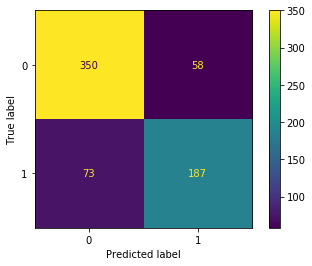

In [97]:
plot_confusion_matrix(m_logistic, X_train_engineered, y_train) # "estimator" is scikit-learn's name for model

In [98]:
# score model: function to output the scores

def scoreModels(model, x_train_engineered, ytrue, ypred):
    print('Accuracy of ' + str(model) + ' is: ' + str(model.score(x_train_engineered, ytrue)))
    print('Precision of ' + str(model) + ' is: ' + str(precision_score(ytrue, ypred)))
    print('Recall of ' + str(model) + ' is: ' + str(recall_score(ytrue, ypred)))
    print('F1 of ' + str(model) + ' is: ' + str(f1_score(ytrue, ypred)))
    
scoreModels(m_logistic, X_train_engineered, y_train, ypred_log)

Accuracy of LogisticRegression() is: 0.8038922155688623
Precision of LogisticRegression() is: 0.763265306122449
Recall of LogisticRegression() is: 0.7192307692307692
F1 of LogisticRegression() is: 0.7405940594059407


## Random forest model

### Random forest with feature engineered data set

In [99]:
# Run on the same feature-engineered data set
m_RandFor = RandomForestClassifier(n_estimators = 100, max_depth = 3)    # n_estimators: no. trees; more trees are more robust
m_RandFor.fit(X_train_engineered, y_train)

RandomForestClassifier(max_depth=3)

In [100]:
# Calculate predicted y values

ypred_RandFor = m_RandFor.predict(X_train_engineered)

In [101]:
# Score model

scoreModels(m_RandFor, X_train_engineered, y_train, ypred_RandFor)

Accuracy of RandomForestClassifier(max_depth=3) is: 0.8173652694610778
Precision of RandomForestClassifier(max_depth=3) is: 0.8026315789473685
Recall of RandomForestClassifier(max_depth=3) is: 0.7038461538461539
F1 of RandomForestClassifier(max_depth=3) is: 0.75


### Random Forest using un-engineered data

#### Step 1: All of the data (kitchen sink approach) -- Clean data

In [121]:
# Drop non-numeric / not straightforward to convert to numeric cols
X_train_kitchen = X_train.drop(['Name', 'Ticket', 'Cabin', 'Age_Scaled'], axis = 1)

# convert sex and embarkation to numeric
sex = {'female' : 1, 'male' : 0}

X_train_kitchen['Sex'] = X_train_kitchen['Sex'].replace(sex)

3.0

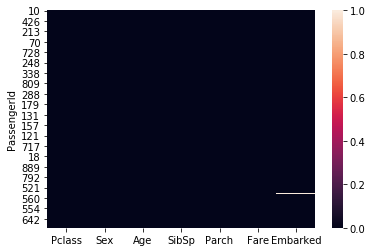

In [120]:
sns.heatmap(X_train_kitchen.isna())

#### Random forest model for all data

In [119]:
m_RandFor_all = RandomForestClassifier(n_estimators = 100, max_depth = 3)
m_RandFor_all.fit(X_train_kitchen, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').